# Deep Learning: Final Project
## Classification of histopathology images
Submitted by: [ Gaya Gorodecki 206105371 ]

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import cv2

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, MaxPooling2D, Dropout, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, InputLayer

from sklearn.metrics import confusion_matrix
from seaborn import heatmap 

import warnings
warnings.filterwarnings('ignore')

#### Load images from 'colorectal_histology' and split to train and test

In [2]:
# Load dataset and convert to numbay array
(img_train, label_train) = tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

# Split dataset to 90% train and 10% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_train, label_train, test_size=0.1, random_state=42)

# Normalize images
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

print('img_train.shape = ',X_train.shape)
print('label_train.shape = ',y_train.shape)
print('img_test.shape = ',X_test.shape)
print('label_test.shape = ',y_test.shape)

img_train.shape =  (4500, 150, 150, 3)
label_train.shape =  (4500,)
img_test.shape =  (500, 150, 150, 3)
label_test.shape =  (500,)


In [3]:
labels = ['Tumor epithelium','Stroma (simple)','Stroma (complex)','Immune cells','Debris or mucus','Mucosal glands', 'Adipose tissue', 'Background']

#### Check train and test has all classes.

In [4]:
print("Train classes: ", np.unique(y_train))
print("Test classes: ", np.unique(y_test))

Train classes:  [0 1 2 3 4 5 6 7]
Test classes:  [0 1 2 3 4 5 6 7]


### Plot some exemples of test set classes

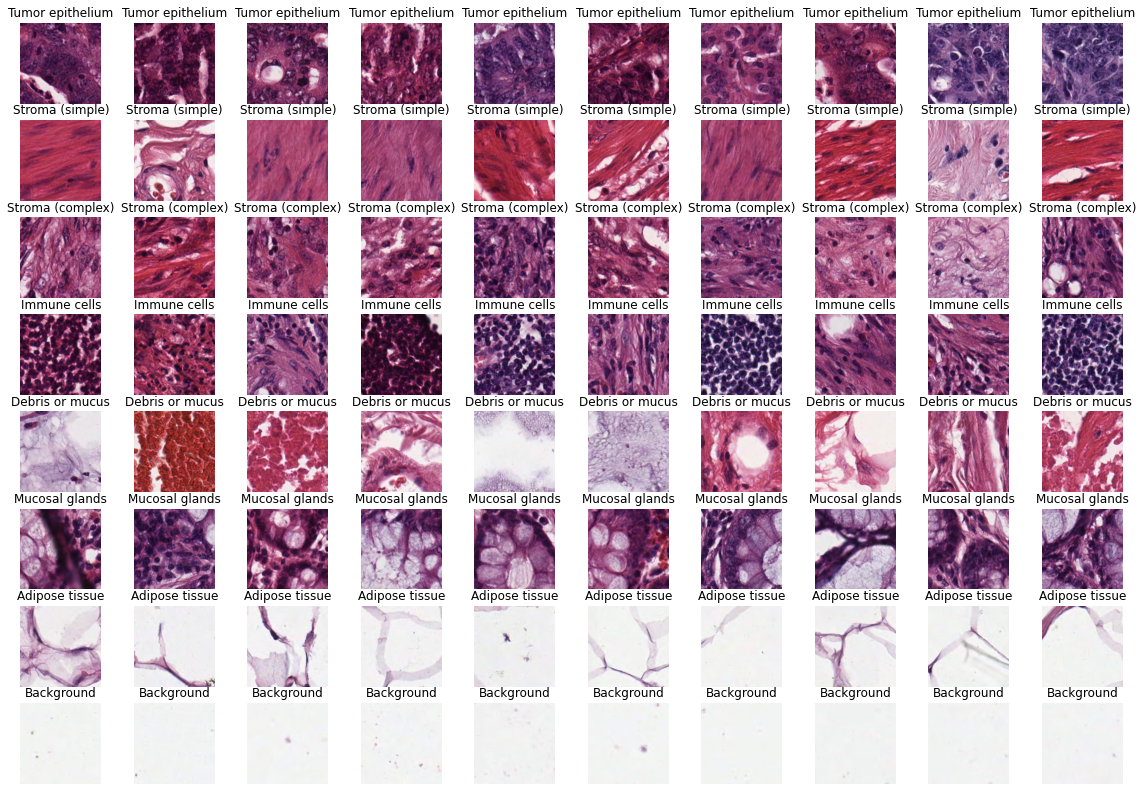

In [5]:
plt.figure(figsize=(20,14))

for i in range(8):

  X_labels = X_test[np.where(y_test==i)]
  for j in range(10):
    plt.subplot(8,10,(i*10)+j+1)
    plt.imshow(X_labels[j])
    plt.title(labels[i])
    plt.axis('off')
plt.show()

## Train several schemes:

In [6]:
def plot_results(history):
  
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'],':r')
    plt.plot(history.history['val_loss'],'.-r')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'],':b')
    plt.plot(history.history['val_accuracy'],'.-b')
    plt.ylim([0, 1])
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.grid()

#### First scheme - 'vgg-like' with BatchNormalization:

Model: "BatchNormalization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 64) 

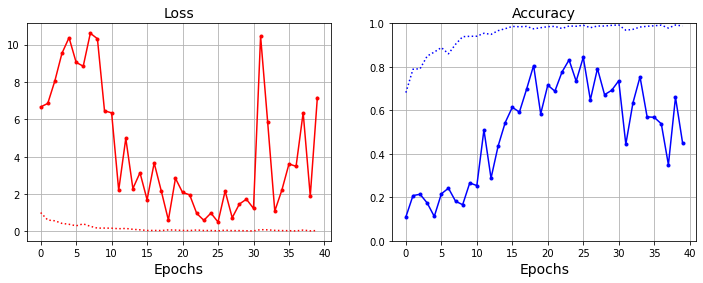

In [7]:
model_1 = Sequential(name='BatchNormalization')
model_1.add(InputLayer((150, 150, 3)))

# block1
model_1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2,2)))

# block2
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2,2)))

# block3
model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D((2,2)))

# block4
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.5))
model_1.add(Dense(8, activation='softmax'))

# Compile the model with 'adam' optimaizer
model_1.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

model_1.summary()

# train the model with validation 
history_1 = model_1.fit(X_train, y_train, epochs=40, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)

print('train accuracy = ',history_1.history['accuracy'][-1])
print('test accuracy = ',history_1.history['val_accuracy'][-1])

plot_results(history_1)

#### Second scheme - VGG16 new "top"

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 32776     
Total params: 48,305,992
Trainable params: 33,591,304
Non-trainable params: 14,714,688
_________________________________________________________________
train accuracy =  0.9766666889190674
test accuracy =  0.8880000114440918


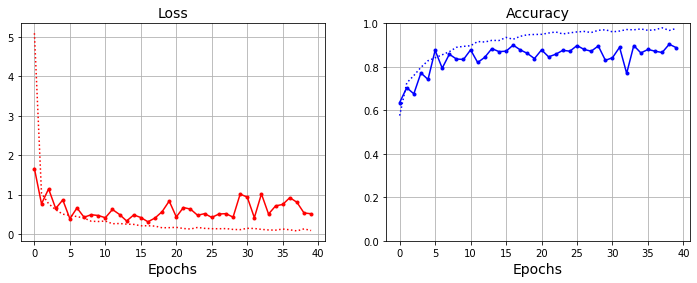

In [8]:
model_2 = Sequential()

#  Add the VGG16 (without its "top") as the new model's first layer 
from tensorflow.keras.applications import VGG16
model_2.add(VGG16(include_top=False, input_shape=(150,150,3)))

#  Add a new "top": 
model_2.add(Flatten())
model_2.add(Dense(4096, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation="softmax"))

#  Freeze the weights in the first layer
model_2.layers[0].trainable = False
model_2.summary()

# Compile the model with RMSprop optimizer
model_2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation 
history_2 = model_2.fit(X_train, y_train, epochs=40, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)

print('train accuracy = ',history_2.history['accuracy'][-1])
print('test accuracy = ',history_2.history['val_accuracy'][-1])

plot_results(history_2)

#### Third scheme - train with VGG layers:

train accuracy =  0.9984444379806519
test accuracy =  0.9039999842643738


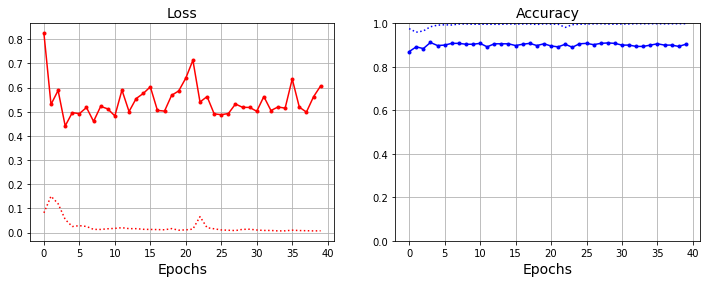

In [9]:
model_2.layers[0].trainable = True

# Compile the model with SGD optimizer
from tensorflow.keras.optimizers import SGD
my_opt = SGD(learning_rate=0.0001, momentum=0.9)

model_2.compile(optimizer=my_opt, # SGD
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation 
history_3 = model_2.fit(X_train, y_train, epochs=40, batch_size=128,
            validation_data=(X_test, y_test), verbose=0)    

print('train accuracy = ',history_3.history['accuracy'][-1])
print('test accuracy = ',history_3.history['val_accuracy'][-1]) 

plot_results(history_3)

#### Fourth scheme - Add Data Augmentation

train accuracy =  0.9917188882827759
test accuracy =  0.9291666746139526


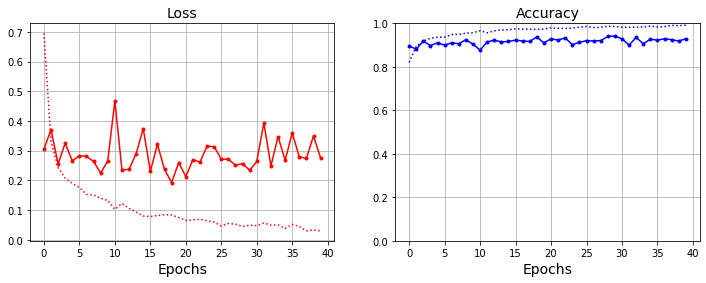

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataGen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=3,
                             height_shift_range=3,
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True)

train_generator = dataGen.flow(X_train, y_train, batch_size=32)

validationGen = ImageDataGenerator()
validation_generator = validationGen.flow(X_test,y_test,batch_size=32)

# Compile the model with SGD optimizer
model_2.compile(optimizer=my_opt, # SGD
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation 
history_4 = model_2.fit(train_generator, epochs=40, 
                      steps_per_epoch=X_train.shape[0]//32,
                      validation_steps=X_test.shape[0]//32, 
                      validation_data=(validation_generator), verbose=0)

print('train accuracy = ',history_4.history['accuracy'][-1])
print('test accuracy = ',history_4.history['val_accuracy'][-1])

plot_results(history_4)

### Comparison between the models:

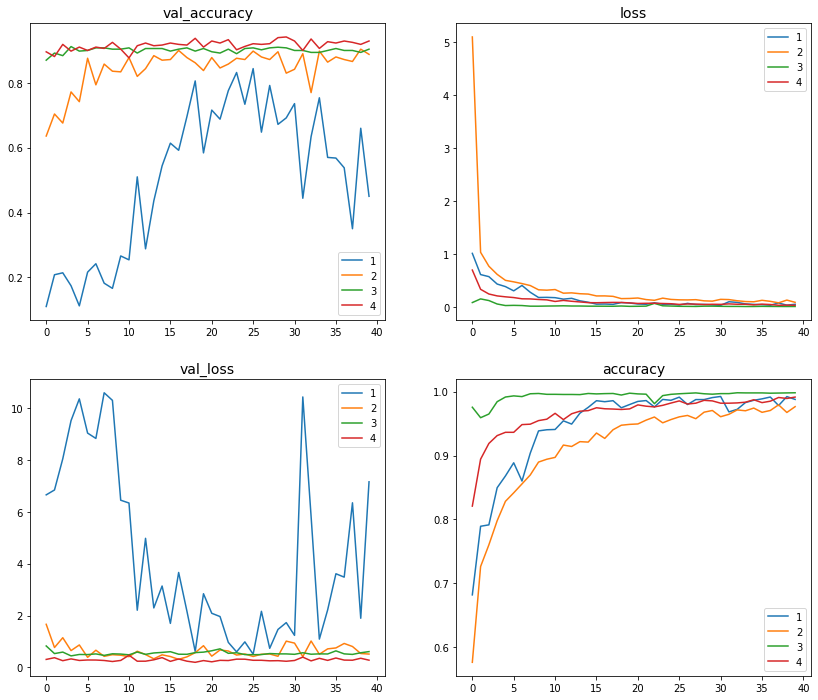

In [11]:
graphs = {'loss', 'accuracy', 'val_loss', 'val_accuracy'}

plt.figure(figsize=(14,12))

for i, gr in enumerate(graphs):
    plt.subplot(2,2,i+1)
    for j,history_ in enumerate([history_1, history_2,history_3, history_4]):
        plt.plot(history_.history[gr], label=j+1)
        plt.legend()
        plt.title(gr,fontsize=14)

<table>
  <tr>
    <th>Model</th>
    <th>#parameters</th>
    <th>epochs</th>
    <th>train accuracy</th>
    <th>test accuracy</th>
  </tr>
    
  <!-- copy this block once for every model you tested -->  
  <tr> 
    <td>BatchNormalization</td>   <!-- Model -->
    <td></td> <!-- #parameters -->
    <td></td> <!-- epochs -->
    <td></td> <!-- train accuracy -->
    <td></td> <!-- test accuracy -->
  </tr>
  <tr>
    <td>VGG16 top</td>   <!-- Model -->
    <td></td> <!-- #parameters -->
    <td></td> <!-- epochs -->
    <td></td> <!-- train accuracy -->
    <td></td> <!-- test accuracy -->
  </tr>
  <tr> 
    <td>VGG16</td>   <!-- Model -->
    <td></td> <!-- #parameters -->
    <td></td> <!-- epochs -->
    <td></td> <!-- train accuracy -->
    <td></td> <!-- test accuracy -->
  <tr> 
    <td>Data Augmentation</td>   <!-- Model -->
    <td></td> <!-- #parameters -->
    <td></td> <!-- epochs -->
    <td></td> <!-- train accuracy -->
    <td></td> <!-- test accuracy -->
  </tr>
    
 
</table>

## confusion matrix

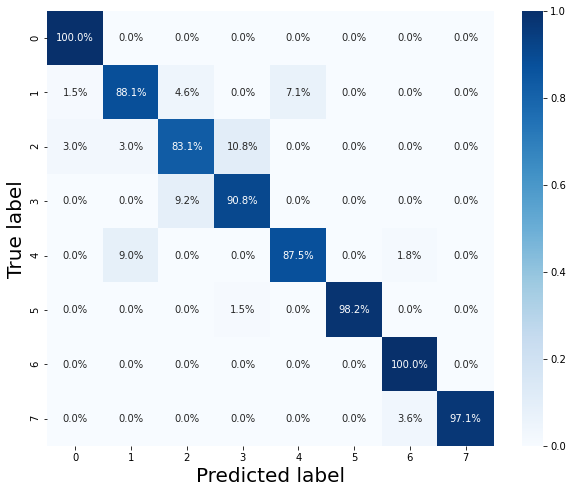

In [12]:
y_hat = model_2.predict(X_test)
y_hat = np.argmax(y_hat, axis=1)
CM = confusion_matrix(y_test, y_hat)
CM = CM / CM.sum(axis=1)

plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.1%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

## Preproccess input

In [13]:
features_extractor = keras.Model(inputs=model_2.inputs, outputs=model_2.layers[-2].output)

from tensorflow.keras.applications.vgg16 import preprocess_input 

dataGen = ImageDataGenerator(preprocessing_function=preprocess_input) # tf.keras.applications.vgg16.preprocess_input

X_test = X_test.astype("float32") * 255 # back to original
X_test = preprocess_input(X_test) # vgg16 preproccess

test_Gen = dataGen.flow(X_test, y_test, batch_size = 500, shuffle=False)

x_batch, y_batch = test_Gen.next()

features_4096D = features_extractor.predict(x_batch)
print("features_4096D.shape =", features_4096D.shape)

features_4096D.shape = (500, 4096)


## euclidean distances

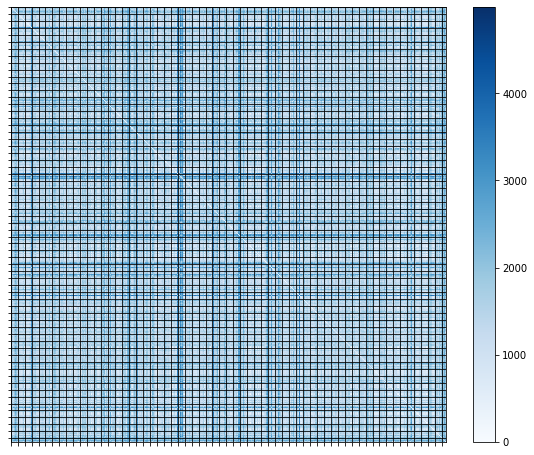

In [14]:
from sklearn.metrics.pairwise import euclidean_distances

D = euclidean_distances(features_4096D)

plt.figure(figsize=(10,8))
plt.imshow(D,cmap='Blues')
plt.xticks(np.arange(0,500,8)-0.5,labels=[])
plt.yticks(np.arange(0,500,8)-0.5,labels=[])
plt.grid(color='k') 
plt.colorbar()
plt.show()

## Visualizing the labelled data distribution in 2-D

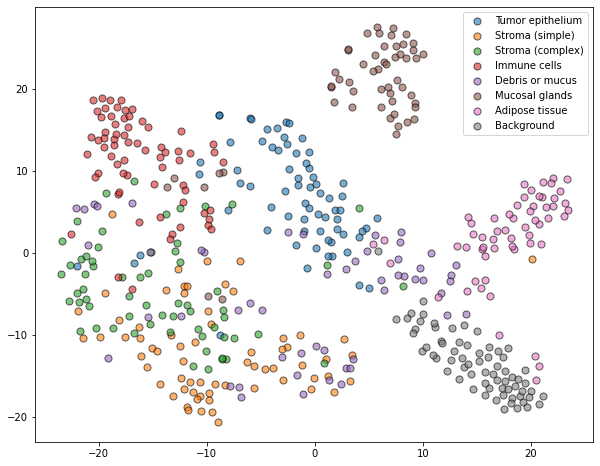

In [15]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(features_4096D)

plt.figure(figsize=(10,8))
for i in range(8):
  x_label = X_embedded[np.where(y_hat==i)]
  plt.scatter(x_label[:,0], x_label[:,1], s=50, alpha=0.6, label=labels[i], edgecolors='k')
plt.legend()
plt.show()

# Classification

### Load the 'colorectal_histology_large' dataset

In [16]:
img_test = tfds.as_numpy(tfds.load(
    'colorectal_histology_large',
    split='test',
    batch_size=-1
))

img_test = img_test['image']
img_test = img_test.astype("float32") / 255

print('img_test.shape = ',img_test.shape)

img_test.shape =  (10, 5000, 5000, 3)


### Classification result  

*   Split each image to patches of 150x150x3 
*   predict each patch img
*   set color of classification on the color_pred image and add it to list
*   set tumor classification (probability) as the color of tumor_prob image and add it to lise





In [17]:
# Colors list for labels.
labels_colors = [(1.0, 0.4, 0.2),(0.2, 0.7, 0.3),(1.0, 0.8, 0.7),(0.3, 0.7, 0.9),
                 (0.8, 0.5, 0.9),(0.9, 0.9, 0.9),(0.5, 0.5, 0.5),(0.0, 0.0, 0.0)]

color_predictions_list = []
tumor_epithelium_prob_list = []

for image in range(10):

  original_image = img_test[image]

  color_pred = np.zeros_like(original_image)
  tumor_prob = np.zeros_like(original_image)

  # Add pedding with zeros to predict all large image.
  padded_image = np.pad(original_image,((50,50),(50,50),(0,0)))

  for i in range(0, original_image.shape[0], 75):
    for j in range(0, original_image.shape[1], 75):
      
      # Get img patch of 150*150*3
      img_patch = padded_image[i:i+150,j:j+150,:]
      img_patch = np.expand_dims(img_patch, axis=0)
            
      y_hat = model_2.predict(img_patch)
      prediction = np.argmax(y_hat)
      for color_index in range(3):
        color_pred[i:i+150,j:j+150,color_index] = labels_colors[prediction][color_index]
        tumor_prob[i:i+150,j:j+150,color_index] = y_hat[0][color_index]

  color_predictions_list.append(color_pred)
  tumor_epithelium_prob_list.append(tumor_prob)

### Result: Original images / Classification result / Tumor epithelium probaility

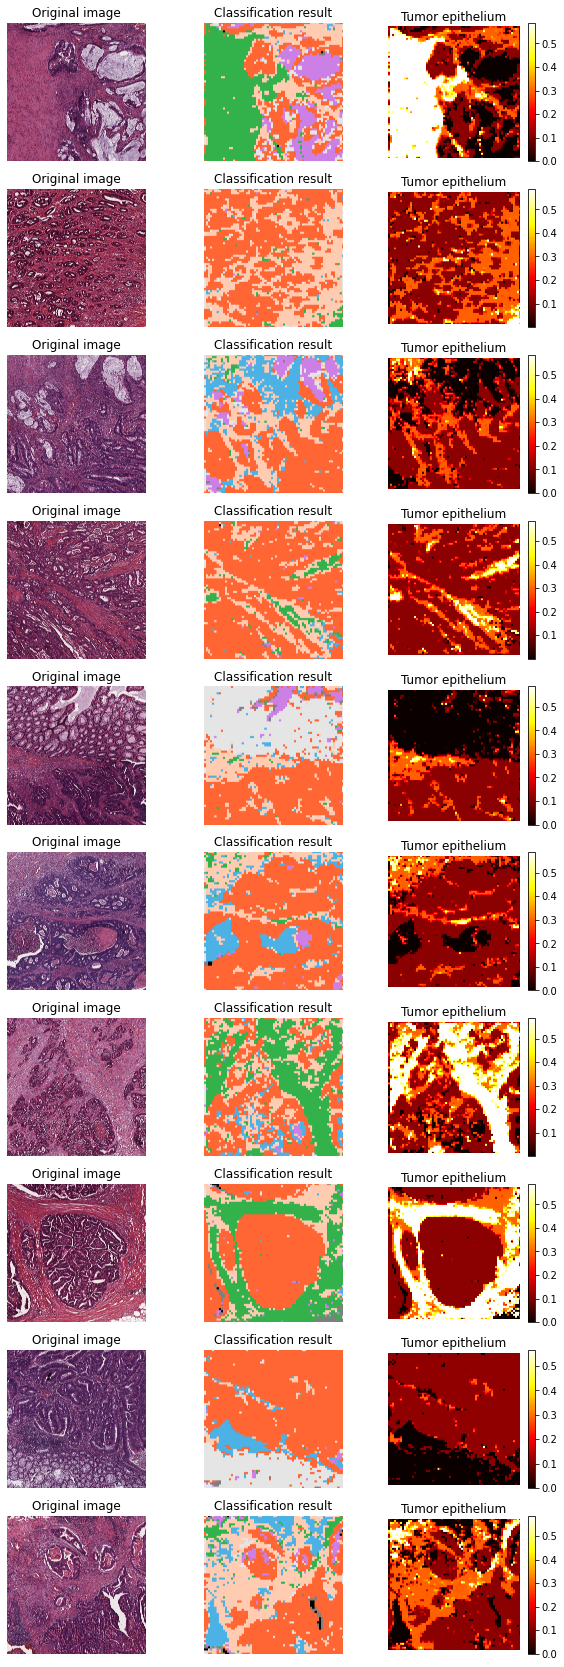

In [18]:
ind = 1
plt.figure(figsize=(10,30)) 

for i in range(10): 
    plt.subplot(10,3,ind)
    plt.imshow(img_test[i])
    plt.title('Original image')
    plt.axis('off')
    ind += 1

    plt.subplot(10,3,ind)
    plt.imshow(color_predictions_list[i])
    plt.title('Classification result')
    plt.axis('off')
    ind += 1

    plt.subplot(10,3,ind)
    gray = cv2.cvtColor(tumor_epithelium_prob_list[i], cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='hot')
    plt.title('Tumor epithelium')
    plt.axis('off')
    plt.colorbar()
    ind += 1

plt.show()